## Using Machine Learning To Identify Fraud in Enron Scandal
</br>

### By: Jonathan Grays
</br>

### February 2020

### Table of Contents


### Overview
</br>

Write an overview of Enron's history leading up to and including fraud


### Project Goal
The goal of this project is to create a machine learning program/algorithm that will try to identify persons of interest in the Enron Financial Scandal.  Machine learning is a useful means to do this as it can be scaled up to datasets of almost any size.  Fortunately, since we know the persons of interest ahead of times, we can use a supervised algorithm to construct our identifier.  This can be accomplished by picking the features within our dataset that separate our POIs from the non-POIS in the best way.

We will first start our project with answering some basic questions about the data.  Once we have the basic information we will move on to visualizing our features and any correlations/outliers that may exist.

In [1]:
# Import starting packages
# Others will be added as necessary

import sys
sys.path.append("..\\tools\\")
import pickle
import sklearn
import pandas as pd
import pprint

# Bring data into a dictionary

enron_dict = pd.read_pickle(r"final_project_dataset.pkl")

# Ensure correct datatype
print('Dataset Type: ', type(enron_dict))

Dataset Type:  <class 'dict'>


### Questions about Dataset

1. How many people are in the dataset?
2. Names of people in dataset?
3. What features do we have for them? (What info is recorded?)
4. Who are the POIs? (Persons of Interest)
5. Do any features stick out as initially useful?

</br>
1. <u>How many people are in the dataset?</u>

In [2]:
# Print the number of people in dataset

print("Number of people in dataset: ", len(enron_dict))

Number of people in dataset:  146


</br>
2. <u>Names of people in dataset?</u>

In [3]:
# Using pretty print to display names of people in the dataset
# Will be sorted by Last Name

printing = pprint.PrettyPrinter()

names = sorted(enron_dict.keys())

</br>
3. <u>What features do we have for each person?</u>

In [4]:
# Printing an example person and their corresponding dictionary

print("One example from the dataset:")

printing.pprint(enron_dict['BLACHMAN JEREMY M'])

One example from the dataset:
{'bonus': 850000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeremy.blachman@enron.com',
 'exercised_stock_options': 765313,
 'expenses': 84208,
 'from_messages': 14,
 'from_poi_to_this_person': 25,
 'from_this_person_to_poi': 2,
 'loan_advances': 'NaN',
 'long_term_incentive': 831809,
 'other': 272,
 'poi': False,
 'restricted_stock': 189041,
 'restricted_stock_deferred': 'NaN',
 'salary': 248546,
 'shared_receipt_with_poi': 2326,
 'to_messages': 2475,
 'total_payments': 2014835,
 'total_stock_value': 954354}


</br>
4. <u>Who are the POIs?</u>

In [5]:
# Import dictionary as a dataframe

enron_df = pd.DataFrame(enron_dict)

# Flip Names to be row headers
enron_df = enron_df.transpose()

In [6]:
# Display names and number of POIs

poi_list = enron_df.index[enron_df['poi'] == True].tolist()

print("Number of POIs: ", len(poi_list))

printing.pprint(poi_list)

Number of POIs:  18
['HANNON KEVIN P',
 'COLWELL WESLEY',
 'RIEKER PAULA H',
 'KOPPER MICHAEL J',
 'SHELBY REX',
 'DELAINEY DAVID W',
 'LAY KENNETH L',
 'BOWEN JR RAYMOND M',
 'BELDEN TIMOTHY N',
 'FASTOW ANDREW S',
 'CALGER CHRISTOPHER F',
 'RICE KENNETH D',
 'SKILLING JEFFREY K',
 'YEAGER F SCOTT',
 'HIRKO JOSEPH',
 'KOENIG MARK E',
 'CAUSEY RICHARD A',
 'GLISAN JR BEN F']


</br>
5. <u>Do any features stick out as initially useful?</u>

- Since we are dealing with financial fraud, features like 'bonus', 'salary', 'total_payments', 'exercised_stock_options' and 'total_stock_value' seem like a good place to start. Also, 'from_poi_to_this_person' and 'from_this_person_to_poi' caught my attention as well since these could lead to patterns of communication with the POIs (paper trails).

- I will create a new feature for this dataset that is derived from the emails to and from a POI for a given person in our list.  A lot of direct communication with a POI may not be all that useful to us (if say a non-POI directly reported to a POI, they would certainly have had a good amount of email correspondence).  So instead, let's transform these features into a proportion of email correspondence with a POI to total emails sent/received per person.

- Before creating this new feature, I will need to convert my columns that contain numeric data into float types.

In [7]:
# Sets selected columns (all but email_address and POI) to numeric/float type

cols = ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus','restricted_stock_deferred',
        'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options',
        'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi',
        'restricted_stock','director_fees']
enron_df[cols] = enron_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

enron_df = enron_df.reset_index()

enron_df.rename(columns={"index": "name"}, inplace=True)

- There are quite a few NaN values in this dataset, which could be a bit discouraging.  Depending on the column that those NaNs are under they could be omitted or overwritten with zeroes.

In [8]:
# Added a feature listing the fraction of emails to and from POIs
# Also fills in 'NaN' spaces
enron_df['fraction_emails_to_poi'] = enron_df['from_this_person_to_poi'].fillna(0.0)/ (enron_df['to_messages'].fillna(0.0) + enron_df['from_this_person_to_poi'].fillna(0.0))

enron_df['fraction_emails_from_poi'] = enron_df['from_poi_to_this_person'].fillna(0.0)/ (enron_df['from_messages'].fillna(0.0) + enron_df['from_poi_to_this_person'].fillna(0.0))

enron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 24 columns):
name                         146 non-null object
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                146 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null object
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_recei

In [9]:
# Adding 'fraction_emails_to_poi' to enron dictionary

for name in enron_dict:
    
    enron_dict[name]['fraction_emails_to_poi'] = float(enron_dict[name]['from_this_person_to_poi'])/(float(enron_dict[name]['to_messages']) + (float(enron_dict[name]['from_this_person_to_poi'])))
    enron_dict[name]['fraction_emails_from_poi'] = float(enron_dict[name]['from_poi_to_this_person'])/(float(enron_dict[name]['from_poi_to_this_person']) + (float(enron_dict[name]['from_messages'])))
    
printing.pprint(enron_dict['BLACHMAN JEREMY M'])

{'bonus': 850000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeremy.blachman@enron.com',
 'exercised_stock_options': 765313,
 'expenses': 84208,
 'fraction_emails_from_poi': 0.6410256410256411,
 'fraction_emails_to_poi': 0.0008074283407347598,
 'from_messages': 14,
 'from_poi_to_this_person': 25,
 'from_this_person_to_poi': 2,
 'loan_advances': 'NaN',
 'long_term_incentive': 831809,
 'other': 272,
 'poi': False,
 'restricted_stock': 189041,
 'restricted_stock_deferred': 'NaN',
 'salary': 248546,
 'shared_receipt_with_poi': 2326,
 'to_messages': 2475,
 'total_payments': 2014835,
 'total_stock_value': 954354}


- Now lets visualize some of the financial data to see if we can see any trends and/or outliers that would shape our perspective of this data.
</br>
</br>

- First we shall plot Salary and Bonus information

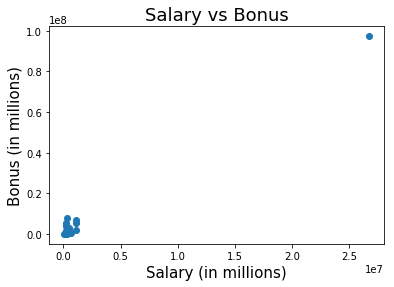

In [10]:
# Plot of salary (x-axis) and bonus (y-axis)

import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Salary vs Bonus', fontsize = 18)
plt.scatter('salary', 'bonus', data = enron_df)
plt.xlabel('Salary (in millions)', fontsize = 15)
plt.ylabel('Bonus (in millions)', fontsize = 15)
plt.show()



- Immediately we see a very distinct outlier.  This entry is definitely skewing our data.  In it's current state we can't really infer much of what the graph is trying to tell us.  We should take a look at the entry to make sure this is not an error.

In [11]:
enron_df[(enron_df['salary']>2000000)][['name','salary','bonus','poi']]

,name,salary,bonus,poi
103,TOTAL,26704229.0,97343619.0,False


- The name "TOTAL" must be referring to some sort of calculation done on the data (likely the sum of all salaries in the dataset).  Since this information is also something we can calculate ourselves, I will be removing this entry and replotting.

In [12]:
## remove the outlier and verify it is gone.

df_remove_total = enron_df[ enron_df['name'] == 'TOTAL' ]

enron_df = enron_df.drop(df_remove_total.index, axis=0)
    
enron_df[(enron_df['salary']>2000000)][['name','salary','bonus','poi']]

,name,salary,bonus,poi


Text(25.636258680555557, 0.5, 'Bonus (in millions)')

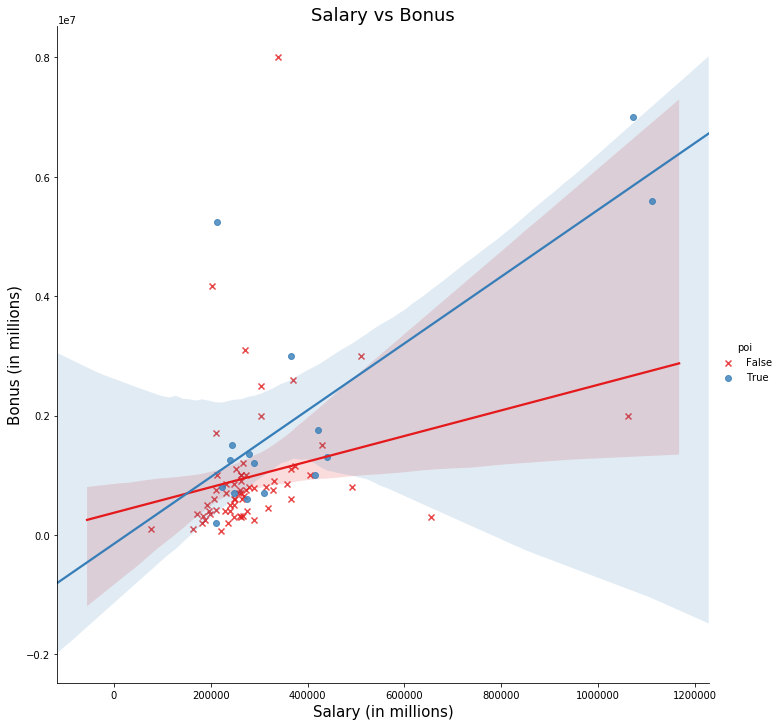

In [13]:
# Replot salary vs bonus // Also importing Seaborn for graph readability

import seaborn as sns

sns.lmplot(x='salary', y= 'bonus', hue='poi', data=enron_df, palette='Set1', height=10, markers=['x','o'])
plt.title('Salary vs Bonus', fontsize = 18)
plt.xlabel('Salary (in millions)', fontsize = 15)
plt.ylabel('Bonus (in millions)', fontsize = 15)

- Now we have a much better look at the Salary and Bonus data!

</br>

- Immediately, a few outliers stand out.  Let's find out who they are.

In [14]:
# Looking at 

print("Salary Outliers: \n", enron_df[(enron_df['salary'] > 1000000)][['name', 'salary', 'poi']])

print("Bonus Outliers: \n", enron_df[(enron_df['bonus'] > 4000000)][['name', 'bonus', 'poi']])

Salary Outliers: 
                    name     salary    poi
64        LAY KENNETH L  1072321.0   True
95   SKILLING JEFFREY K  1111258.0   True
128      FREVERT MARK A  1060932.0  False
Bonus Outliers: 
                    name      bonus    poi
42      LAVORATO JOHN J  8000000.0  False
64        LAY KENNETH L  7000000.0   True
81     BELDEN TIMOTHY N  5249999.0   True
95   SKILLING JEFFREY K  5600000.0   True
108     ALLEN PHILLIP K  4175000.0  False


- This has identified 3 POIs!  Two of which (Kenneth Lay and Jeffrey Skilling) are noted in both outliers lists... interesting.

</br>

- Just who are these two?  Research indicates that these two men are:
    * Jeffrey Skilling: Former CEO and Chairman of Enron.  Resigned from company in August 2001
    * Kenneth Lay: CEO, Founder and Chairman of Enron during the scandal.

</br>

- Beings that these men were both CEOs of Enron, it does makes sense that they would be at the top of the earnings for both earnings and salary.  What is suspicious is that the top three salaried people listed made nearly DOUBLE what the fourth ranked salaried person made.  That seems like quite a gap, even for a CEO.

</br>



### Custom Feature Exploration

- Now let's plot out and explore the custom features we created, "fraction_emails_to_poi" and "fraction_emails_to_poi".

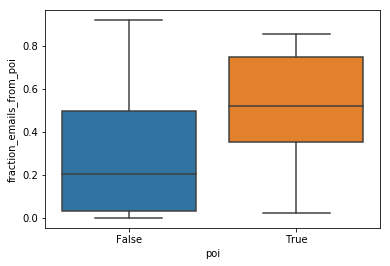

In [15]:
# Boxplot for out "fraction_emails_to_poi" feature

sns.boxplot(x='poi',y='fraction_emails_from_poi',data= enron_df)

- It seems that the email percentage sent to PoI from other POIs is higher than the percentage sent by non-POIs.  This could be attributed to most of the POIs being upper management and above (indicating they would work closely with eachother).  Regardless, I will include this in the list of features for the algorithm.

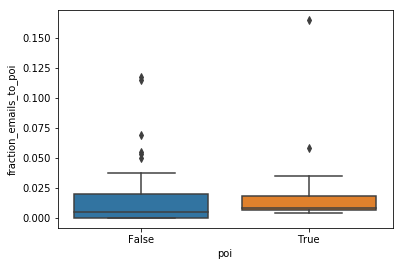

In [16]:
# Boxplot for out "fraction_emails_from_poi" feature

sns.boxplot(x='poi',y='fraction_emails_to_poi',data= enron_df)

- There does not seem to be much of a difference when it comes to the emails sent from a POI.  This will not be used to train our machine learning algorithm.

### Missing Values

- Now, let's take a look at the features that are missing values.  Depending on the number of missing values in the respective features we may choose to omit them from the dataset.

In [17]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

enron_df.isnull().sum()

name                           0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                  0
exercised_stock_options       44
expenses                      51
from_messages                 59
from_poi_to_this_person       59
from_this_person_to_poi       59
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       59
to_messages                   59
total_payments                21
total_stock_value             20
fraction_emails_to_poi        59
fraction_emails_from_poi      59
dtype: int64

- From the dataframe info listed above, we can see several features are missing a lot of information.  We should as much info out as we feel comfortable with to cut down on any additional noise they would provide.  Such attributes I recommend removing are:

    * email_address
    * deferral_payments
    * loan_advances
    * restricted_stock_deferred
    * director_fees
</br>
- After looking at the data I also recommend removing the rows for Total, as this info can be calculated separately if need be.  We should also remove the info for Eugene Lockhart as all of his information is NaN.

In [18]:
# Removing features

enron_df.drop(['email_address', 'deferral_payments', 'loan_advances',
               'restricted_stock_deferred', 'director_fees'], axis = 1, inplace = True)

# Replacing NaN values with 0.0
enron_df.fillna(0.0, inplace=True)

enron_df.head()

,name,bonus,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_emails_to_poi,fraction_emails_from_poi
0,METTS MARK,600000.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,1740.0,False,585062.0,365788.0,702.0,807.0,1061827.0,585062.0,0.001238,0.567164
1,BAXTER JOHN C,1200000.0,-1386055.0,6680544.0,11200.0,0.0,0.0,0.0,1586055.0,2660303.0,False,3942714.0,267102.0,0.0,0.0,5634343.0,10623258.0,0.000000,0.000000
2,ELLIOTT STEVEN,350000.0,-400729.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,12961.0,False,1788391.0,170941.0,0.0,0.0,211725.0,6678735.0,0.000000,0.000000
3,CORDES WILLIAM R,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,False,386335.0,0.0,58.0,764.0,0.0,1038185.0,0.000000,0.454545
4,HANNON KEVIN P,1500000.0,-3117011.0,5538001.0,34039.0,32.0,32.0,21.0,1617011.0,11350.0,True,853064.0,243293.0,1035.0,1045.0,288682.0,6391065.0,0.019700,0.500000


In [19]:
# Taking dataframe and converting to dictionary for processing
enron_df.set_index('name')
enron_dict = enron_df.to_dict('index')

# Removing entry from dictionary because of lack of data
enron_dict.pop('LOCKHART EUGENE E',0)

#Removing outlier as this will skew data
enron_dict.pop('TOTAL',0)


0

In [20]:
# Creating features list

complete_features_list = enron_df.columns.tolist()

# Removing 'name' and moving 'poi' to the beginning of the list
complete_features_list.pop(0)

features_list = ['poi']

for n in complete_features_list:
    features_list.append(n)

printing.pprint(features_list)

['poi',
 'bonus',
 'deferred_income',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value',
 'fraction_emails_to_poi',
 'fraction_emails_from_poi']


In [21]:
printing.pprint(enron_dict)

{0: {'bonus': 600000.0,
     'deferred_income': 0.0,
     'exercised_stock_options': 0.0,
     'expenses': 94299.0,
     'fraction_emails_from_poi': 0.5671641791044776,
     'fraction_emails_to_poi': 0.0012376237623762376,
     'from_messages': 29.0,
     'from_poi_to_this_person': 38.0,
     'from_this_person_to_poi': 1.0,
     'long_term_incentive': 0.0,
     'name': 'METTS MARK',
     'other': 1740.0,
     'poi': False,
     'restricted_stock': 585062.0,
     'salary': 365788.0,
     'shared_receipt_with_poi': 702.0,
     'to_messages': 807.0,
     'total_payments': 1061827.0,
     'total_stock_value': 585062.0},
 1: {'bonus': 1200000.0,
     'deferred_income': -1386055.0,
     'exercised_stock_options': 6680544.0,
     'expenses': 11200.0,
     'fraction_emails_from_poi': 0.0,
     'fraction_emails_to_poi': 0.0,
     'from_messages': 0.0,
     'from_poi_to_this_person': 0.0,
     'from_this_person_to_poi': 0.0,
     'long_term_incentive': 1586055.0,
     'name': 'BAXTER JOHN C',
  

      'shared_receipt_with_poi': 1258.0,
      'to_messages': 1328.0,
      'total_payments': 1099100.0,
      'total_stock_value': 1918887.0},
 31: {'bonus': 0.0,
      'deferred_income': 0.0,
      'exercised_stock_options': 98718.0,
      'expenses': 0.0,
      'fraction_emails_from_poi': 0.0,
      'fraction_emails_to_poi': 0.0,
      'from_messages': 0.0,
      'from_poi_to_this_person': 0.0,
      'from_this_person_to_poi': 0.0,
      'long_term_incentive': 0.0,
      'name': 'WHALEY DAVID A',
      'other': 0.0,
      'poi': False,
      'restricted_stock': 0.0,
      'salary': 0.0,
      'shared_receipt_with_poi': 0.0,
      'to_messages': 0.0,
      'total_payments': 0.0,
      'total_stock_value': 98718.0},
 32: {'bonus': 700000.0,
      'deferred_income': 0.0,
      'exercised_stock_options': 0.0,
      'expenses': 37172.0,
      'fraction_emails_from_poi': 0.03209271227991977,
      'fraction_emails_to_poi': 0.05012336060251915,
      'from_messages': 4343.0,
      'from_po

      'restricted_stock': 0.0,
      'salary': 0.0,
      'shared_receipt_with_poi': 0.0,
      'to_messages': 0.0,
      'total_payments': 213071.0,
      'total_stock_value': 0.0},
 46: {'bonus': 0.0,
      'deferred_income': -17500.0,
      'exercised_stock_options': 0.0,
      'expenses': 0.0,
      'fraction_emails_from_poi': 0.0,
      'fraction_emails_to_poi': 0.0,
      'from_messages': 26.0,
      'from_poi_to_this_person': 0.0,
      'from_this_person_to_poi': 0.0,
      'long_term_incentive': 0.0,
      'name': 'POWERS WILLIAM',
      'other': 0.0,
      'poi': False,
      'restricted_stock': 0.0,
      'salary': 0.0,
      'shared_receipt_with_poi': 12.0,
      'to_messages': 653.0,
      'total_payments': 0.0,
      'total_stock_value': 0.0},
 47: {'bonus': 750000.0,
      'deferred_income': 0.0,
      'exercised_stock_options': 436515.0,
      'expenses': 0.0,
      'fraction_emails_from_poi': 0.0,
      'fraction_emails_to_poi': 0.0,
      'from_messages': 0.0,
      'f

      'from_this_person_to_poi': 49.0,
      'long_term_incentive': 0.0,
      'name': 'REDMOND BRIAN L',
      'other': 0.0,
      'poi': False,
      'restricted_stock': 381285.0,
      'salary': 96840.0,
      'shared_receipt_with_poi': 1063.0,
      'to_messages': 1671.0,
      'total_payments': 111529.0,
      'total_stock_value': 7890324.0},
 80: {'bonus': 0.0,
      'deferred_income': 0.0,
      'exercised_stock_options': 1599641.0,
      'expenses': 0.0,
      'fraction_emails_from_poi': 0.0,
      'fraction_emails_to_poi': 0.0,
      'from_messages': 0.0,
      'from_poi_to_this_person': 0.0,
      'from_this_person_to_poi': 0.0,
      'long_term_incentive': 93750.0,
      'name': 'BAZELIDES PHILIP J',
      'other': 874.0,
      'poi': False,
      'restricted_stock': 0.0,
      'salary': 80818.0,
      'shared_receipt_with_poi': 0.0,
      'to_messages': 0.0,
      'total_payments': 860136.0,
      'total_stock_value': 1599641.0},
 81: {'bonus': 5249999.0,
      'deferred_in

       'deferred_income': -201641.0,
       'exercised_stock_options': 0.0,
       'expenses': 129142.0,
       'fraction_emails_from_poi': 0.0,
       'fraction_emails_to_poi': 0.0,
       'from_messages': 0.0,
       'from_poi_to_this_person': 0.0,
       'from_this_person_to_poi': 0.0,
       'long_term_incentive': 0.0,
       'name': 'BAY FRANKLIN R',
       'other': 69.0,
       'poi': False,
       'restricted_stock': 145796.0,
       'salary': 239671.0,
       'shared_receipt_with_poi': 0.0,
       'to_messages': 0.0,
       'total_payments': 827696.0,
       'total_stock_value': 63014.0},
 132: {'bonus': 0.0,
       'deferred_income': 0.0,
       'exercised_stock_options': 664375.0,
       'expenses': 0.0,
       'fraction_emails_from_poi': 0.10416666666666667,
       'fraction_emails_to_poi': 0.0013937282229965157,
       'from_messages': 215.0,
       'from_poi_to_this_person': 25.0,
       'from_this_person_to_poi': 2.0,
       'long_term_incentive': 0.0,
       'name': 'MCC

       'from_poi_to_this_person': 52.0,
       'from_this_person_to_poi': 6.0,
       'long_term_incentive': 71023.0,
       'name': 'GLISAN JR BEN F',
       'other': 200308.0,
       'poi': True,
       'restricted_stock': 393818.0,
       'salary': 274975.0,
       'shared_receipt_with_poi': 874.0,
       'to_messages': 873.0,
       'total_payments': 1272284.0,
       'total_stock_value': 778546.0}}


### Selecting Features

</br>

- To decide on the best features to use for our project, I will run the list through the SelectKBest feature selection algorithm.  With these results we will take the top six and use them to train our classifier(s).  

In [22]:
# Importing necessary feature metrics and classifiers

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from feature_format import featureFormat, targetFeatureSplit


dataset = enron_dict

In [23]:
# Using Naive_Bayes classifier

data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size = 0.3, random_state = 42)

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

NB_before_accuracy = accuracy_score(labels_test, pred)

print("Naive_Bayes Classifier:")
print("Accuracy: ", NB_before_accuracy)
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

Naive_Bayes Classifier:
Accuracy:  0.8181818181818182
Precision:  0.2857142857142857
Recall:  0.4


- Before any tuning, our Naive Bayes classifier gives us the following scores:
    * Accuracy of 81.82%.
    * Precision score of 0.29
    * Recall score of 0.40

In [24]:
# Using K Nearest Neighbors

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

KNN_before_accuracy = accuracy_score(labels_test, pred)

print("K Nearest Neighbors Classifier:")
print("Accuracy: ", KNN_before_accuracy)
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

K Nearest Neighbors Classifier:
Accuracy:  0.8409090909090909
Precision:  0.25
Recall:  0.2


In [31]:
# Running GridSearchCV to choose best features

parameters = {'kernel':('poly', 'rbf'), 'C':[1, 10]}

svr = svm.SVC(gamma = 'scale')
clf = GridSearchCV(svr, parameters, cv=5)
clf.fit(features_train, labels_train)

print(clf.best_params_)

{'C': 1, 'kernel': 'rbf'}


C:\Users\jgrays\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
